## Installation and imports

In [74]:
#@title Install required packages.
try:
    from google.colab import files  # checks if you are on google colab
    !rm -rf CogModelingRNNsTutorial
    !git clone https://github.com/whyhardt/CogModelingRNN.git
    %pip install -e CogModelingRNN/CogModelingRNNsTutorial
    !cp CogModelingRNN/CogModelingRNNsTutorial/*py CogModelingRNN
    %pip install pysindy
    _ON_COLAB = True
except:
    print('Not on Google Colab. Assuming you already installed the required packages.')

Not on Google Colab. Assuming you already installed the required packages.


In [75]:
#@title Import libraries
import sys
import os
import warnings
from typing import Callable, Tuple, Iterable, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# deepmind related libraries
import haiku as hk
import jax
import optax

import pysindy as ps

warnings.filterwarnings("ignore")

# RL libraries
sys.path.append('resources')  # add source directoy to path
from resources import bandits, hybrnn_forget, rnn_utils

In [77]:
#@title make update rule of Q-/SINDyNetwork-Agents adjustable and make values of RNN-Agent visible

class AgentQuadQ(bandits.AgentQ):
  
  def __init__(
      self,
      alpha: float=0.2,
      beta: float=3.,
      n_actions: int=2,
      forgetting_rate: float=0.,
      perseveration_bias: float=0.,
      ):
    super().__init__(alpha, beta, n_actions, forgetting_rate, perseveration_bias)
  
  def update(self,
            choice: int,
            reward: float):
    """Update the agent after one step of the task.

    Args:
      choice: The choice made by the agent. 0 or 1
      reward: The reward received by the agent. 0 or 1
    """
    
    # Decay q-values toward the initial value.
    self._q = (1-self._forgetting_rate) * self._q + self._forgetting_rate * self._q_init

    # Update chosen q for chosen action with observed reward.
    self._q[choice] = self._q[choice] - self._alpha * self._q[choice]**2 + self._alpha * reward


class AgentSindy(bandits.AgentQ):

  def __init__(
      self,
      alpha: float=0.2,
      beta: float=3.,
      n_actions: int=2,
      forgetting_rate: float=0.,
      perservation_bias: float=0.,):
    super().__init__(alpha, beta, n_actions, forgetting_rate, perservation_bias)

    self._update_rule = lambda q, choice, reward: (1 - self._alpha) * q[choice] + self._alpha * reward
    self._update_rule_formula = None

  def set_update_rule(self, update_rule: callable, update_rule_formula: str=None):
    self._update_rule=update_rule
    self._update_rule_formula=update_rule_formula

  @property
  def update_rule(self):
    if self._update_rule_formula is not None:
      return self._update_rule_formula
    else:
      return f'{self._update_rule}'

  def update(self, choice: int, reward: int):

    for c in range(self._n_actions):
      self._q[c] = self._update_rule(self._q[c], int(c==choice), reward)


class AgentNetwork_VisibleState(bandits.AgentNetwork):

  def __init__(self,
               make_network: Callable[[], hk.RNNCore],
               params: hk.Params,
               n_actions: int = 2,
               state_to_numpy: bool = False,
               habit=False):
    super().__init__(make_network=make_network, params=params, n_actions=n_actions, state_to_numpy=state_to_numpy)
    self.habit = habit

  @property
  def q(self):
    if self.habit:
      return self._state[2], self._state[3]
    else:
      return self._state[3].reshape(-1)

dict_agents = {
    'basic': lambda alpha, beta, n_actions, forgetting_rate, perseveration_bias: bandits.AgentQ(alpha, beta, n_actions, forgetting_rate, perseveration_bias),
    'quad_q': lambda alpha, beta, n_actions, forgetting_rate, perseveration_bias: AgentQuadQ(alpha, beta, n_actions, forgetting_rate, perseveration_bias)
}

In [78]:
def get_q(experiment: bandits.BanditSession, agent: Union[bandits.AgentQ, bandits.AgentNetwork, AgentSindy]):
  """Compute Q-Values of a specific agent for a specific experiment.

  Args:
      experiment (bandits.BanditSession): _description_
      agent (_type_): _description_

  Returns:
      _type_: _description_
  """
  
  choices = np.expand_dims(experiment.choices, 1)
  rewards = np.expand_dims(experiment.rewards, 1)
  qs = np.zeros((experiment.choices.shape[0], agent._n_actions))
  choice_probs = np.zeros((experiment.choices.shape[0], agent._n_actions))
  
  agent.new_sess()
  
  for trial in range(experiment.choices.shape[0]):
    qs[trial] = agent.q
    choice_probs[trial] = agent.get_choice_probs()
    agent.update(int(choices[trial]), float(rewards[trial]))
    
  return qs, choice_probs


def parse_equation_for_sympy(eq):
    # replace all blank spaces with '*' where necessary
    # only between number and letter in exactly this order
    blanks = [i for i, ltr in enumerate(eq) if ltr == ' ']
    for blank in blanks:
        if (eq[blank+1].isalpha() or eq[blank-1].isdigit()) and (eq[blank+1].isalpha() or eq[blank+1].isdigit()):
            eq = eq[:blank] + '*' + eq[blank+1:]
    
    # replace all '^' with '**'
    eq = eq.replace('^', '**')
    
    # remove all [k]
    eq = eq.replace('[k]', '')

    return eq

def make_sindy_data(
    dataset,
    agent: bandits.AgentQ,
    sessions=-1,
    get_choices=True,
    # keep_sessions=False,
    ):

  # Get training data for SINDy
  # put all relevant signals in x_train

  if not isinstance(sessions, Iterable) and sessions == -1:
    # use all sessions
    sessions = np.arange(len(dataset))
  else:
    # use only the specified sessions
    sessions = np.array(sessions)
    
  if get_choices:
    n_control = 2
  else:
    n_control = 1
  
  # if keep_sessions:
  #   # concatenate all sessions along the trial dimensinon -> shape: (n_trials, n_sessions, n_features)
  #   choices = np.expand_dims(np.stack([dataset[i].choices for i in sessions], axis=1), -1)
  #   rewards = np.expand_dims(np.stack([dataset[i].rewards for i in sessions], axis=1), -1)
  #   qs = np.stack([dataset[i].q for i in sessions], axis=1)
  # else:
  # concatenate all sessions along the trial dimensinon -> shape: (n_trials*n_sessions, n_features)
  # choices = np.expand_dims(np.concatenate([dataset[i].choices for i in sessions], axis=0), -1)
  # rewards = np.expand_dims(np.concatenate([dataset[i].rewards for i in sessions], axis=0), -1)
  # qs = np.concatenate([dataset[i].q for i in sessions], axis=0)
  
  choices = np.stack([dataset[i].choices for i in sessions], axis=0)
  rewards = np.stack([dataset[i].rewards for i in sessions], axis=0)
  qs = np.stack([dataset[i].q for i in sessions], axis=0)
  
  if not get_choices:
    raise NotImplementedError('Only get_choices=True is implemented right now.')
    n_sessions = qs.shape[0]
    n_trials = qs.shape[1]*qs.shape[2]
    qs_all = np.zeros((n_sessions, n_trials))
    r_all = np.zeros((n_sessions, n_trials))
    c_all = None
    # concatenate the data of all arms into one array for more training data
    index_end_last_arm = 0
    for index_arm in range(agent._n_actions):
      index = np.where(choices==index_arm)[0]
      r_all[index_end_last_arm:index_end_last_arm+len(index)] = rewards[index]
      qs_all[index_end_last_arm:index_end_last_arm+len(index)] = qs[index, index_arm].reshape(-1, 1)
      index_end_last_arm += len(index)
  else:
    choices_oh = np.zeros((len(sessions), choices.shape[1], agent._n_actions))
    for sess in sessions:
      # one-hot encode choices
      choices_oh[sess] = np.eye(agent._n_actions)[choices[sess]]
      # add choices as control parameter; no sorting required then
      # qs_all = np.concatenate([qs[sess, :, i] for i in range(agent._n_actions)], axis=1)
      # c_all = np.concatenate([choices[:, sess, i] for i in range(agent._n_actions)], axis=1)
      # r_all = np.concatenate([rewards for _ in range(agent._n_actions)], axis=1)
      # concatenate all qs values of one sessions along the trial dimension
      qs_all = np.concatenate([np.stack([np.expand_dims(qs_sess[:, i], axis=-1) for i in range(agent._n_actions)], axis=0) for qs_sess in qs], axis=0)
      c_all = np.concatenate([np.stack([c_sess[:, i] for i in range(agent._n_actions)], axis=0) for c_sess in choices_oh], axis=0)
      r_all = np.concatenate([np.stack([r_sess for _ in range(agent._n_actions)], axis=0) for r_sess in rewards], axis=0)
  
  # get observed dynamics
  x_train = qs_all
  feature_names = ['q']

  # get control
  control_names = []
  control = np.zeros((*x_train.shape[:-1], n_control))
  if get_choices:
    control[:, :, 0] = c_all
    control_names += ['c']
  control[:, :, n_control-1] = r_all
  control_names += ['r']
  
  feature_names += control_names
  
  print(f'Shape of Q-Values is: {x_train.shape}')
  print(f'Shape of control parameters is: {control.shape}')
  print(f'Feature names are: {feature_names}')
  
  # make x_train and control sequences instead of arrays
  x_train = [x_train_sess for x_train_sess in x_train]
  control = [control_sess for control_sess in control]
 
  return x_train, control, feature_names


# RNN Reinforcement Learning

## Set up agent and generate training data

In [79]:
#@title Select dataset type.
#@markdown ## Select dataset:

dataset_type = 'synt'  #@param ['synt', 'real']

#@markdown Set up parameters for synthetic data generation:
if dataset_type == 'synt':
    # agent parameters
    agent_kw = 'basic'  #@param ['basic', 'quad_q'] 
    gen_alpha = .25 #@param
    gen_beta = 5 #@param
    forgetting_rate = 0.1 #@param
    perseveration_bias = 0.  #@param
    # environment parameters
    non_binary_reward = False #@param
    n_actions = 2 #@param
    sigma = .1  #@param
    
    # experiement parameters
    n_trials_per_session = 200  #@param
    n_sessions = 220  #@param
    
    # setup
    environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_rewards=non_binary_reward)
    agent = dict_agents[agent_kw](gen_alpha, gen_beta, n_actions, forgetting_rate, perseveration_bias)  
  
    dataset_train, experiment_list_train = bandits.create_dataset(
        agent=agent,
        environment=environment,
        n_trials_per_session=n_trials_per_session,
        n_sessions=n_sessions)

    dataset_test, experiment_list_test = bandits.create_dataset(
        agent=agent,
        environment=environment,
        n_trials_per_session=n_trials_per_session,
        n_sessions=n_sessions)

#@markdown Set up parameters for loading rat data from Miller et al 2019.
elif dataset_type == 'real':
    # TODO: ys are not the rewards but the following choices!!!!
    raise NotImplementedError('This is not implemented yet.')

    path = 'data/bahrami_100.csv'
    data = pd.read_csv(path)
    xs = data['action'].values
    ys = data['reward'].values
    episodes = np.unique(data['participant_id'].values)
    # reshape xs and ys to be (n_trials_per_episode, n_episodes, 1). Take the variable episodes as the index for the dim 'n_episodes'
    train_test_ratio = 0.8
    n_episodes_train = int(len(episodes)*train_test_ratio)
    n_episodes_test = len(episodes) - n_episodes_train

    xs = xs.reshape(-1, len(episodes), 1)
    ys = ys.reshape(-1, len(episodes), 1)
    
    # one-hot encode xs
    xs = jax.nn.one_hot(xs[:, :, 0], num_classes=int(np.max(np.unique(xs[:, 0, 0])+1)))
    # delay xs by one time step to have previous choices
    xs = np.concatenate((np.zeros((1, *xs.shape[1:])), xs[:-1, :, :]), axis=0)
    # add one-time-step delayed reward as feature to xs
    reward_delayed = np.concatenate((np.zeros((1, *ys.shape[1:])), ys[:-1, :, :]), axis=0)
    xs = np.concatenate((xs, reward_delayed), axis=-1)
    
    xs_train = xs[:, :n_episodes_train]
    ys_train = ys[:, :n_episodes_train]
    xs_test = xs[:, n_episodes_train:]
    ys_test = ys[:, n_episodes_train:]
    
    n_actions = xs.shape[-1]# - 1  # -1 because of the delayed reward 
    n_trials_per_session = xs.shape[0] 
    n_sessions = xs_train.shape[1]
    
    dataset_train = rnn_utils.DatasetRNN(xs_train, ys_train)
    dataset_test = rnn_utils.DatasetRNN(xs_test, ys_test)
    
    experiment_list_train = None
    experiment_list_test = None

else:
  raise NotImplementedError(
      (f'dataset_type {dataset_type} not implemented. '
       'Please select from drop-down list.'))

## Train SINDy on actual data and replace agent's update rule with SINDy update rule

The target equation for SINDy with forgetting is:

$$Q_\text{k+1}=(1-f)Q_\text{k} + f Q_0 - \alpha (1-f) c Q_\text{k} - \alpha f Q_0 c + \alpha c r$$

For the values $f=0.1$, $\alpha=0.25$, $Q_0=0.5$ this gives the constants
$$Q_\text{k+1}=0.9 Q_\text{k} + 0.05 - 0.225 c Q_\text{k} -  0.0125 c + 0.25 c r$$

In [80]:
get_choices = True
poly_order = 3
threshold = 0.01
dt = 1

custom_lib_functions = [
    # sub-library which is always included    
    lambda q,c,r: q,
    lambda q,c,r: r,
    lambda q,c,r: np.power(q, 2),
    lambda q,c,r: q*r,
    lambda q,c,r: np.power(r, 2),
    # sub-library if the possible action was chosen
    lambda q,c,r: c,
    lambda q,c,r: c*q,
    lambda q,c,r: c*r,
    lambda q,c,r: c*np.power(q, 2),
    lambda q,c,r: c*q*r,
    lambda q,c,r: c*np.power(r, 2),
]

custom_lib_names = [
    # part library which is always included
    lambda q,c,r: f'{q}',
    lambda q,c,r: f'{r}',
    lambda q,c,r: f'{q}^2',
    lambda q,c,r: f'{q}*{r}',
    lambda q,c,r: f'{r}^2',
    # part library if the possible action was chosen
    lambda q,c,r: f'{c}',
    lambda q,c,r: f'{c}*{q}',
    lambda q,c,r: f'{c}*{r}',
    lambda q,c,r: f'{c}*{q}^2',
    lambda q,c,r: f'{c}*{q}*{r}',
    lambda q,c,r: f'{c}*{r}^2',
]

# solution library for f=0.5, alpha=0.25, Q_init=0.5
# solution_lib = ps.CustomLibrary(
#     library_functions=[lambda q,c,r: 0.5*q + 0.25 - 0.125*c*q - 0.0675*c + 0.25*c*r],
#     function_names=[lambda q,c,r: f'0.5*q + 0.25 - 0.125*c*q - 0.0675*c + 0.25*c*r'],
#     include_bias=False,
#     library_ensemble=False,
# )

In [81]:
#@title Fit SINDy to actual dataset
# library = custom_lib  # custom_lib, poly_lib, solution_lib
ensemble = False
library_ensemble = False

# library_datasindy = ps.CustomLibrary(
#     library_functions=custom_lib_functions,
#     function_names=custom_lib_names,
#     include_bias=True,
# )

library_datasindy = ps.PolynomialLibrary(poly_order)

experiment_list_datasindy = None

if dataset_type == 'synt':
    x_train, control, feature_names = make_sindy_data(experiment_list_train, agent, get_choices=get_choices)

    datasindy = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold, verbose=True, alpha=0.1),
        feature_library=library_datasindy,
        discrete_time=True,
        feature_names=feature_names,
    )
    datasindy.fit(x_train, t=dt, u=control, ensemble=ensemble, library_ensemble=library_ensemble, multiple_trajectories=True)
    datasindy.print()

    # set new sindy update rule and synthesize new dataset
    if not get_choices:
        update_rule_datasindy = lambda q, choice, reward: datasindy.simulate(q[choice], t=2, u=np.array(reward).reshape(1, 1))[-1]
    else:
        update_rule_datasindy = lambda q, choice, reward: datasindy.simulate(q, t=2, u=np.array([choice, reward]).reshape(1, 2))[-1]
    
    datasindyagent = AgentSindy(alpha=0, beta=gen_beta, n_actions=n_actions)
    datasindyagent.set_update_rule(update_rule_datasindy)

    # _, experiment_list_datasindy = bandits.create_dataset(datasindyagent, environment, n_trials_per_session, n_sessions)

Shape of Q-Values is: (440, 200, 1)
Shape of control parameters is: (440, 200, 2)
Feature names are: ['q', 'c', 'r']
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 7.1313e+00 ... 8.3610e-02 ...          9 ... 7.2149e+00
         1 ... 1.2184e+00 ... 8.7565e-02 ...          8 ... 1.3059e+00
         2 ... 3.5782e-01 ... 8.6813e-02 ...          8 ... 4.4463e-01
(q)[k+1] = 0.047 1 + 0.903 q[k] + -0.124 q[k] c[k] + 0.083 c[k] r[k] + 0.011 q[k]^3 + -0.124 q[k] c[k]^2 + 0.083 c[k]^2 r[k] + 0.083 c[k] r[k]^2


For the values $f=0.5$, $\alpha=0.25$ and $Q_0=0.5$ the discovered model should be equal to
$$Q_\text{k+1}=0.9 Q_\text{k} + 0.05 - 0.225 c Q_\text{k} -  0.0125 c + 0.25 c r$$

## Fit a hybrid RNN and train SINDy on RNN dynamics

In [82]:
#@title Set up Hybrid RNN.

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_hidden_state = False  #@param ['True', 'False']

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_previous_values = False  #@param ['True', 'False']

#@markdown If True, learn a value for the forgetting term
fit_forget = False  #@param ['True', 'False']

#@markdown Learn a reward-independent term that depends on past choices.
habit_weight = "0"  #@param [0, 1]
habit_weight = float(habit_weight)

value_weight = 1.  # This is needed for it to be doing RL

rnn_rl_params = {
    's': use_hidden_state,
    'o': use_previous_values,
    'fit_forget': fit_forget,
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': n_actions, 'hidden_size': 16}

def make_hybrnn():
  # model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  model = hybrnn_forget.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model

optimizer_rnn = optax.adam(learning_rate=1e-3)

In [83]:
train = True
load = False  # only relevant if train is True --> Determines whether to load trained parameters and continue training or start new training

# params_path = 'params/params_rnn_forget_f01.pkl'
params_path = 'params/params_rnn_forget_f01_b5.pkl'

if train:
  if load:
    with open(params_path, 'rb') as f:
      rnn_params = pickle.load(f)
    opt_state = rnn_params[1]
    rnn_params = rnn_params[0]
    print('Loaded parameters.')
  else:
    opt_state = None
    rnn_params = None

  # with jax.disable_jit():
  #@title Fit the hybrid RNN
  print('Training the hybrid RNN...')
  rnn_params, opt_state, _ = rnn_utils.fit_model(
      model_fun=make_hybrnn,
      dataset=dataset_train,
      optimizer=optimizer_rnn,
      optimizer_state=opt_state,
      model_params=rnn_params,
      loss_fun='categorical',  # penalized_categorical, categorical
      convergence_thresh=1e-5,
      n_steps_max=10000,
  )

  # save trained parameters
  params = (rnn_params, opt_state)
  with open(params_path, 'wb') as f:
    pickle.dump(params, f)
    
else:
  # load trained parameters
  with open(params_path, 'rb') as f:
    rnn_params = pickle.load(f)[0]
  print('Loaded parameters.')

Training the hybrid RNN...
Step 500 of 500; Loss: 0.5263137; Time: 11.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 0.5261875; Time: 11.5s)
Model not yet converged (convergence_value = 0.000239862) - Running more steps of gradient descent. Time elapsed = 4e-05s.
Step 500 of 500; Loss: 0.5261634; Time: 12.0s)
Model not yet converged (convergence_value = 4.576368e-05) - Running more steps of gradient descent. Time elapsed = 5e-05s.
Step 500 of 500; Loss: 0.5261313; Time: 11.4s)
Model not yet converged (convergence_value = 6.10588e-05) - Running more steps of gradient descent. Time elapsed = 4e-05s.
Step 500 of 500; Loss: 0.5260904; Time: 11.9s)
Model not yet converged (convergence_value = 7.771594e-05) - Running more steps of gradient descent. Time elapsed = 4e-05s.
Step 500 of 500; Loss: 0.5260295; Time: 12.0s)
Model not yet converged (convergence_value = 0.0001156766) - Running more steps of gradient descent. Time el

In [84]:
#@title Synthesize a dataset using the fitted network
hybrnn_agent = AgentNetwork_VisibleState(make_hybrnn, rnn_params, habit=habit_weight==1, n_actions=n_actions)
dataset_hybrnn, experiment_list_hybrnn = bandits.create_dataset(hybrnn_agent, environment, n_trials_per_session, int(n_sessions*1e0))

In [85]:
#@title Fit SINDy to RNN data and synthesize new dataset

threshold = 0.015

x_train, control, feature_names = make_sindy_data(experiment_list_hybrnn, hybrnn_agent, get_choices=get_choices)
# x_train, control, feature_names = make_sindy_data(experiment_list_train, agent, get_choices=get_choices)
# scale q-values between 0 and 1 for more realistic dynamics
x_max = np.max(np.stack(x_train, axis=0))
x_min = np.min(np.stack(x_train, axis=0))
print(f'Dataset characteristics: max={x_max}, min={x_min}')
x_train = [(x - x_min) / (x_max - x_min) for x in x_train]

# library_rnnsindy = ps.CustomLibrary(
#     library_functions=custom_lib_functions,
#     function_names=custom_lib_names,
#     include_bias=True,
# )

library_rnnsindy = ps.PolynomialLibrary(poly_order)

rnnsindy = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, verbose=False, alpha=0.1),
    feature_library=library_rnnsindy,
    discrete_time=True,
    feature_names=feature_names,
)

rnnsindy.fit(x_train, t=dt, u=control, ensemble=True, library_ensemble=False, multiple_trajectories=True)
rnnsindy.print()
sparsity_index = np.sum(rnnsindy.coefficients() < threshold) / rnnsindy.coefficients().size
print(f'Sparsity index: {sparsity_index}')

if not get_choices:
    update_rule_rnnsindy = lambda q, choice, reward: rnnsindy.simulate(q[choice], t=2, u=np.array(reward).reshape(1, 1))[-1]
else:
    update_rule_rnnsindy = lambda q, choice, reward: rnnsindy.simulate(q, t=2, u=np.array([choice, reward]).reshape(1, 2))[-1]

rnnsindyagent = AgentSindy(alpha=0, beta=1, n_actions=n_actions)
rnnsindyagent.set_update_rule(update_rule_rnnsindy)

Shape of Q-Values is: (440, 200, 1)
Shape of control parameters is: (440, 200, 2)
Feature names are: ['q', 'c', 'r']
Dataset characteristics: max=2.675147771835327, min=-1.5127410888671875
(q)[k+1] = 0.043 1 + 0.937 q[k] + -0.017 c[k] + -0.075 q[k]^2 + -0.109 q[k] c[k] + 0.004 q[k] r[k] + -0.017 c[k]^2 + 0.100 c[k] r[k] + 0.041 q[k]^3 + 0.015 q[k]^2 c[k] + -0.006 q[k]^2 r[k] + -0.109 q[k] c[k]^2 + 0.004 q[k] r[k]^2 + -0.017 c[k]^3 + 0.100 c[k]^2 r[k] + 0.100 c[k] r[k]^2
Sparsity index: 0.65


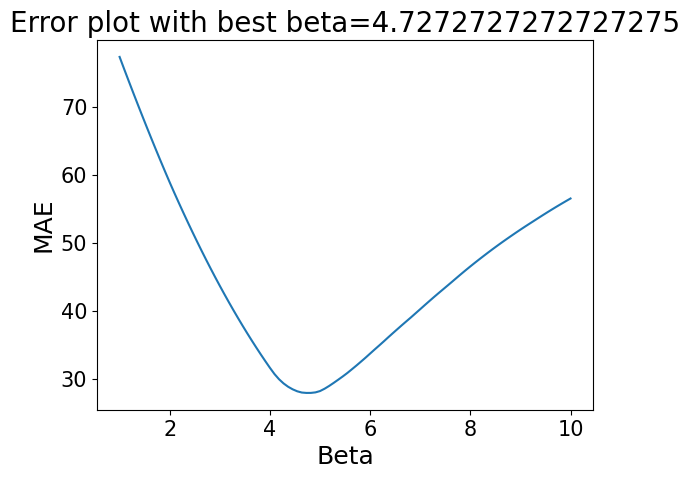

Setting up SINDy agent with beta=4.7272727272727275...


In [86]:
# POST-PROCESSING

# fit beta parameter of softmax by fitting on choice probability of the RNN by simple grid search

# number of observed points
n_points = 100

# epochs
epoch = 0
epochs_max = 100
session_id = 0

# get choice probabilities of the RNN
qs, choice_probs_rnn = get_q(experiment_list_hybrnn[session_id], hybrnn_agent)

# set prior for beta parameter; x_max seems to be a good starting point
# beta_range = np.linspace(x_max-1, x_max+1, n_points)
beta_range = np.linspace(1, 10, n_points)

# get choice probabilities of the SINDy agent for each beta in beta_range
choice_probs_sindy = np.zeros((len(beta_range), len(choice_probs_rnn), n_actions))
for i, beta in enumerate(beta_range):
    sindy_agent = AgentSindy(alpha=0, beta=beta, n_actions=n_actions)
    sindy_agent.set_update_rule(update_rule_rnnsindy)
    _, choice_probs_sindy_beta = get_q(experiment_list_hybrnn[session_id], sindy_agent)
    
    # add choice probabilities to choice_probs_sindy
    choice_probs_sindy[i, :, :] = choice_probs_sindy_beta
    
# get best beta value by minimizing the error between choice probabilities of the RNN and the SINDy agent
errors = np.zeros(len(beta_range))
for i in range(len(beta_range)):
    errors[i] = np.sum(np.abs(choice_probs_rnn - choice_probs_sindy[i]))

# get right beta value
beta = beta_range[np.argmin(errors)]

# plot error plot with best beta value in title
plt.plot(beta_range, errors)
plt.title(f'Error plot with best beta={beta}')
plt.xlabel('Beta')
plt.ylabel('MAE')
plt.show()

print(f'Setting up SINDy agent with beta={beta}...')

rnnsindyagent = AgentSindy(alpha=0, beta=beta, n_actions=n_actions)
rnnsindyagent.set_update_rule(update_rule_rnnsindy)

In [87]:
# perform experiments with the SINDy agent
_, experiment_list_rnnsindy = bandits.create_dataset(rnnsindyagent, environment, n_trials_per_session, 1)#n_sessions)

## Analysis

In [88]:
label_test, label_hybrnn, label_datasindy, label_rnnsindy = 'Test', 'Hybrid RNN', 'SINDy', 'RNN+SINDy'

labels = [
    label_test, 
    label_hybrnn, 
    # label_datasindy, 
    label_rnnsindy,
    ]

save_fig = True
session_id = 0
binary = not non_binary_reward

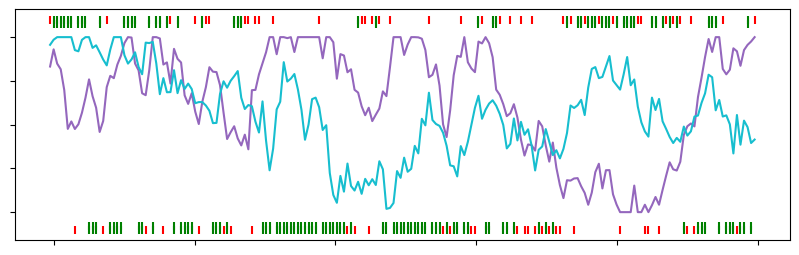

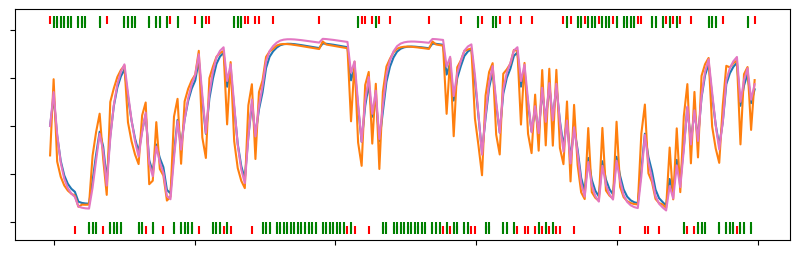

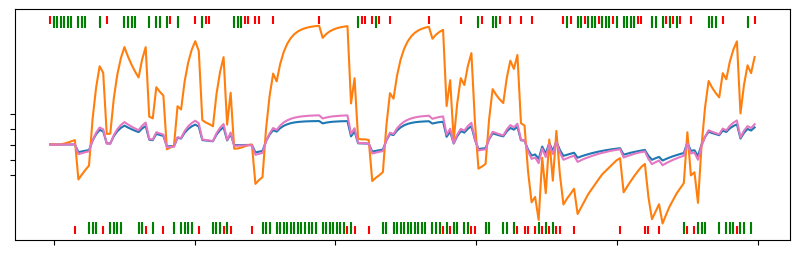

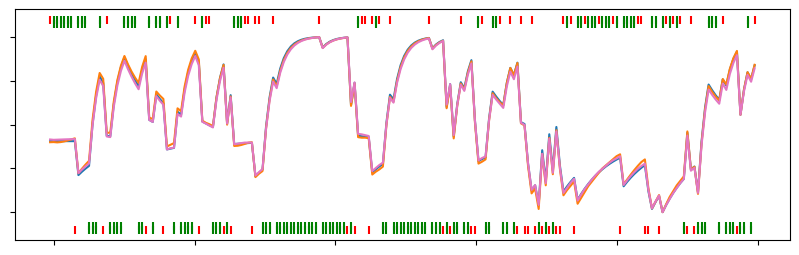

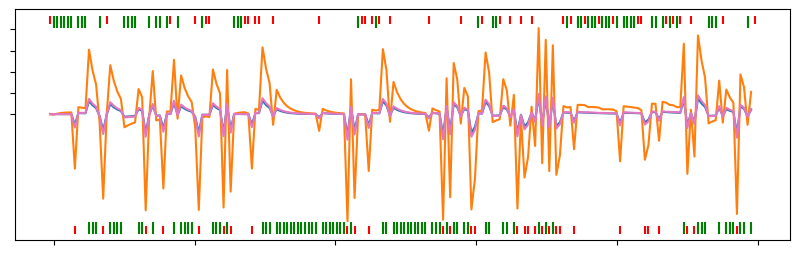

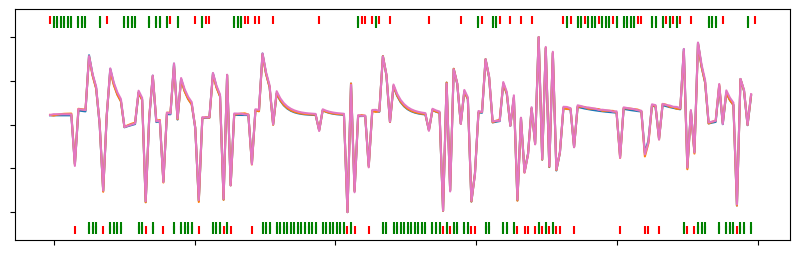

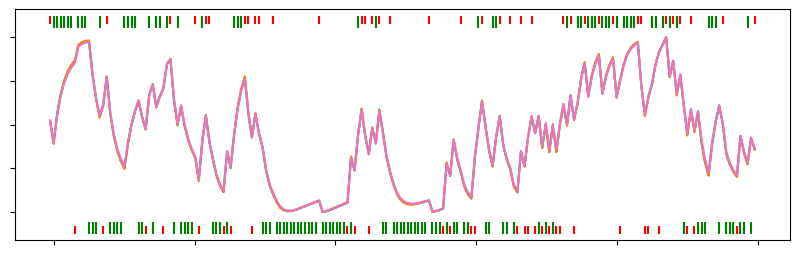

In [89]:
#@title Plot action similarities.

# plot reward probabilities
choices = experiment_list_test[session_id].choices
rewards = experiment_list_test[session_id].rewards

reward_probs = np.stack([experiment_list_test[session_id].timeseries[:, i] for i in range(n_actions)], axis=0)
bandits.plot_session(
    compare=True,
    choices=choices, 
    rewards=rewards, 
    timeseries=reward_probs,
    timeseries_name='', # 'Reward Probabilities'
    # labels=[f'Reward Prob {a}' for a in range(n_actions)],
    color=['tab:purple', 'tab:cyan'],
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/reward_probs.png', dpi=1000)

# plot evolution of Q-Values for same reward and choice trial data

list_probs = []
list_qs = []
if label_test in labels:
    qs_test, probs_test = get_q(experiment_list_test[session_id], agent)
    list_probs.append(np.expand_dims(probs_test, 0))
    list_qs.append(np.expand_dims(qs_test, 0))
if label_hybrnn in labels:
    qs_hybrnn, probs_hybrnn = get_q(experiment_list_test[session_id], hybrnn_agent)
    list_probs.append(np.expand_dims(probs_hybrnn, 0))
    list_qs.append(np.expand_dims(qs_hybrnn, 0))
if label_datasindy in labels:
    qs_datasindy, probs_datasindy = get_q(experiment_list_test[session_id], datasindyagent)
    list_probs.append(np.expand_dims(probs_datasindy, 0))
    list_qs.append(np.expand_dims(qs_datasindy, 0))
if label_rnnsindy in labels:
    qs_rnnsindy, probs_rnnsindy = get_q(experiment_list_test[session_id], rnnsindyagent)
    list_probs.append(np.expand_dims(probs_rnnsindy, 0))
    list_qs.append(np.expand_dims(qs_rnnsindy, 0))

# colors = ['cyan', 'magenta', 'yellow', 'grey']
colors = ['tab:blue', 'tab:orange', 'tab:pink', 'tab:gray']

# concatenate all choice probs and q-values
probs = np.concatenate(list_probs, axis=0)
qs = np.concatenate(list_qs, axis=0)

bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=probs[:, :, 0],
    timeseries_name='', # 'Choice Probabilities',
    # labels=labels,
    color=colors,
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/choice_probs.png', dpi=1000)

bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=qs[:, :, 0],
    timeseries_name='', # 'Q-Values',
    # labels=labels,
    color=colors,
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/q_values.png', dpi=1000)

def normalize(x, axis=1):
    x_min = np.min(x, keepdims=True, axis=axis)
    x_max = np.max(x, keepdims=True, axis=axis)
    return (x - x_min) / (x_max - x_min)

qs_norm = normalize(qs)

bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=qs_norm[:, :, 0],
    timeseries_name='', # 'norm. Q-Values',
    # labels=labels,
    color=colors,
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/q_values_norm.png', dpi=1000)

dqs_trials = np.diff(qs, axis=1)
# for i in range(1, len(qs)):
bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=dqs_trials[:, :, 0],
    timeseries_name='', # 'dQ/dt',
    # labels=labels,
    color=colors,
    binary=binary,
)
# plt.legend()
plt.show() if not save_fig else plt.savefig('plots/dq_dt.png', dpi=1000)

norm_dqs_trials = normalize(dqs_trials)
bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=norm_dqs_trials[:, :, 0],
    timeseries_name='', # 'norm. dQ/dt',
    # labels=labels,
    color=colors,
    binary=binary,
)
# plt.legend()
plt.show() if not save_fig else plt.savefig('plots/dq_dt.png', dpi=1000)

dqs_arms = np.diff(qs, axis=2)
norm_dqs_arms = normalize(dqs_arms)
# dqs_arms /= np.max(np.abs(dqs_arms), axis=(1, 2), keepdims=True)
bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=norm_dqs_arms,
    timeseries_name='', # 'dQ/dArm',
    # # labels=labels,
    color=colors,
    binary=binary,
)
plt.show() if not save_fig else plt.savefig('plots/dq_darm.png', dpi=1000)

# Calculate reward rates
# Plot proportion Leftward Choices over difference in reward prob (left vs right)

# experiment_list = []
# if label_test in labels:
#     print('Test dataset:')
#     bandits.show_total_reward_rate(experiment_list_test)
#     bandits.show_valuemetric(experiment_list_test, label=label_test)
#     experiment_list.append(experiment_list_test)
# if label_hybrnn in labels:
#     print('RNN dataset:')
#     bandits.show_total_reward_rate(experiment_list_hybrnn)
#     bandits.show_valuemetric(experiment_list_hybrnn, label=label_hybrnn)
#     experiment_list.append(experiment_list_hybrnn)
# if label_datasindy in labels:
#     print('Data SINDy dataset:')
#     bandits.show_total_reward_rate(experiment_list_datasindy)
#     bandits.show_valuemetric(experiment_list_datasindy, label=label_datasindy)
#     experiment_list.append(experiment_list_datasindy)
# if label_rnnsindy in labels:
#     print('RNN SINDy dataset:')
#     bandits.show_total_reward_rate(experiment_list_rnnsindy)
#     bandits.show_valuemetric(experiment_list_rnnsindy, label=label_rnnsindy)
#     experiment_list.append(experiment_list_rnnsindy)
# plt.legend()
# plt.show()

# # plot choice similarity over history
# plt.figure()
# plot_action_similarity_to_history(experiment_list, n_steps_back=16, labels=labels, bbox_to_anchor=(1, 1))
# plt.show()

In [90]:
# check for correctly recovered parameters
# groundtruth equation: Q_k+1 = f Q_init + (1-f) Q_k - f * alpha * Q_init * c - (1-f) * alpha * c * Q_k + alpha * c * r
# equations = ['1','q','c','r','q^2','q c','q r','c^2','c r','r^2','q^3','q^2 c','q^2 r','q c^2','q c r','q r^2','c^3','c^2 r','c r^2','r^3']
# similar = [0, 1, 2, 3, 4, 5, 6, 2, 7, 3, 8, 9, 10, 5, ]
# groundtruth coefficients for model w/ and w/o forgetting; for polynomial order 3 library
groundtruth_coeffs = [forgetting_rate * 0.5, 1-forgetting_rate, -0.5*gen_alpha*forgetting_rate, 0, 0, -(1-forgetting_rate)*gen_alpha, 0, 0, gen_alpha, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print('Groundtruth coefficients:')
print(groundtruth_coeffs)
sindy_coeffs = rnnsindy.coefficients().reshape(-1).copy()
print('raw SINDy coefficients:')
print(np.round(sindy_coeffs, 2))
# post-processing of sindy coefficients
# sum up all coefficients that encode the same term if their values are equal
equal_terms = {'c': ['c', 'c^2', 'c^3'], 'r': ['r', 'r^2', 'r^3'], 'c r': ['c r', 'c^2 r', 'c r^2'], 'q c': ['q c', 'q c^2'], 'q r': ['q r', 'q r^2']}
sindy_terms = rnnsindy.get_feature_names()
if not non_binary_reward:
    for term in equal_terms.keys():
        for equal_term in equal_terms[term]:
            if equal_term in sindy_terms:
                if equal_term != term:
                    sindy_coeffs[sindy_terms.index(term)] += sindy_coeffs[sindy_terms.index(equal_term)]
                    sindy_coeffs[sindy_terms.index(equal_term)] = 0

print('post-processed SINDy coefficients:')
# filter all remaining coeffs which are lower than threshold
sindy_coeffs[np.abs(sindy_coeffs) < threshold] = 0
print(np.round(sindy_coeffs, 2))

# get number of correctly recovered terms
correct_terms = 0
for i in range(len(sindy_terms)):
    if groundtruth_coeffs[i] != 0 and sindy_coeffs[i] != 0:
        correct_terms += 1
    elif groundtruth_coeffs[i] == 0 and sindy_coeffs[i] == 0:
        correct_terms += 1

# substract the equal terms
substracted_terms = 0
if not non_binary_reward:
    for term in equal_terms.keys():
        if term in sindy_terms:
            substracted_terms += 1
print(f'Correctly recovered terms: {correct_terms-substracted_terms}/{len(sindy_terms)-substracted_terms}')

# list_coeffs = [[sindy_terms[i], groundtruth_coeffs[i], np.round(sindy_coeffs[i], 2), np.round(rnnsindy.coefficients().reshape(-1)[i], 2)] for i in range(len(sindy_terms))]
# list_features = ['term', 'groundtruth', 'sindy', 'sindy_orig']

list_coeffs = [[sindy_terms[i], groundtruth_coeffs[i], np.round(sindy_coeffs[i], 2)] for i in range(len(sindy_terms))]
list_features = ['term', 'groundtruth', 'sindy']

print(list_features)
for i in range(len(list_coeffs)):
    print(list_coeffs[i])
    
import pandas as pd

pd.DataFrame(list_coeffs, columns=list_features).to_csv('recovered_coeffs_beta'+str(gen_beta)+'.csv', index=False)

Groundtruth coefficients:
[0.05, 0.9, -0.0125, 0, 0, 0.225, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
raw SINDy coefficients:
[ 0.04  0.94 -0.02  0.   -0.08 -0.11  0.   -0.02  0.1   0.    0.04  0.02
 -0.01 -0.11  0.    0.   -0.02  0.1   0.1   0.  ]
post-processed SINDy coefficients:
[ 0.04  0.94 -0.05  0.   -0.08 -0.22  0.    0.    0.3   0.    0.04  0.02
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Correctly recovered terms: 12/15
['term', 'groundtruth', 'sindy']
['1', 0.05, 0.04]
['q', 0.9, 0.94]
['c', -0.0125, -0.05]
['r', 0, 0.0]
['q^2', 0, -0.08]
['q c', 0.225, -0.22]
['q r', 0, 0.0]
['c^2', 0, 0.0]
['c r', 0.25, 0.3]
['r^2', 0, 0.0]
['q^3', 0, 0.04]
['q^2 c', 0, 0.02]
['q^2 r', 0, 0.0]
['q c^2', 0, 0.0]
['q c r', 0, 0.0]
['q r^2', 0, 0.0]
['c^3', 0, 0.0]
['c^2 r', 0, 0.0]
['c r^2', 0, 0.0]
['r^3', 0, 0.0]


IndexError: list index out of range

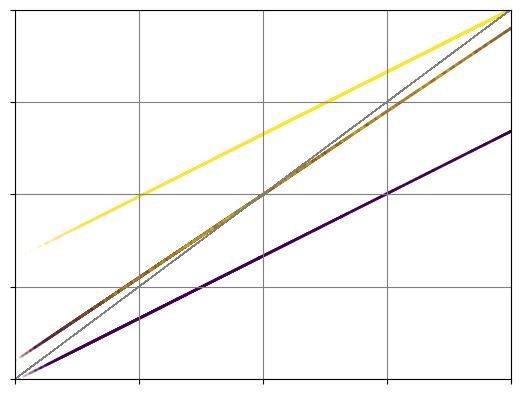

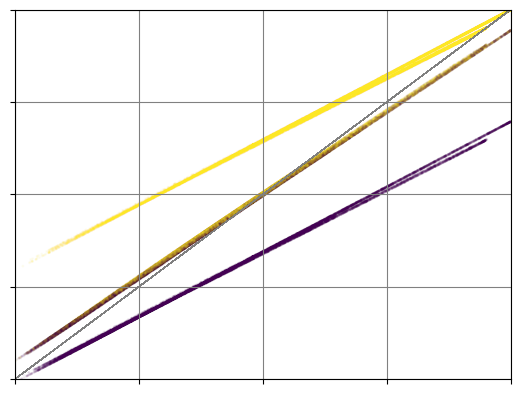

In [91]:
def normalize(x, axis=1):
    x_min = np.min(x) #np.min(x, keepdims=True, axis=axis)
    x_max = np.max(x) #np.max(x, keepdims=True, axis=axis)
    return (x - x_min) / (x_max - x_min)

# take qs_norm as q-values
experiment_dict = {
    label_test: experiment_list_test,
    label_hybrnn: experiment_list_hybrnn, 
    # label_datasindy: experiment_list_datasindy, 
    label_rnnsindy: experiment_list_rnnsindy,
    }

# plot q-value update with old vs new q-values and reward as color
for l in experiment_dict.keys():
    qs = np.stack([experiment_dict[l][session].q for session in range(n_sessions)], axis=1)
    choices = np.stack([experiment_dict[l][session].choices for session in range(n_sessions)], axis=1)
    rewards = np.stack([experiment_dict[l][session].rewards for session in range(n_sessions)], axis=1)
    
    qs = normalize(qs, axis=0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for session in range(n_sessions):
        ax.plot(np.linspace(-10, 10), np.linspace(-10, 10), 'grey', linewidth=0.5) 
        for arm in range(n_actions):
            q_old = qs[:-1, session, arm]
            q_new = qs[1:, session, arm]
            ax.scatter(q_old, q_new, c=experiment_dict[l][session].rewards[:-1], alpha=.05, s=1)
    # set colorbar
    # cbar = plt.colorbar(ax.scatter([], [], c=[], alpha=1, s=1))
    # cbar.set_label('Reward')
    q_min = np.min(qs)
    q_max = np.max(qs)
    ax.set_ylim(q_min, q_max)
    ax.set_xlim(q_min, q_max)
    ax.set_xticks(np.linspace(q_min, q_max, 5))
    ax.set_yticks(np.linspace(q_min, q_max, 5))
    ax.set_xticklabels(['']*5)
    ax.set_yticklabels(['']*5)
    plt.rc('grid', color='grey')
    plt.grid()
    # plt.title(l)
    # plt.xlabel('Old Q-Values')
    # plt.ylabel('New Q-Values')
    plt.show() if not save_fig else plt.savefig(f'plots/q_value_update_{l}.png', dpi=1000)